# Data Science Job Salaries Analysis

**Project:** Analyzing salary trends in the data science job market

**Dataset:** 607 job records with salary information (2020-2022)

**Goals:**
- Understand salary distribution across experience levels
- Analyze impact of remote work on compensation
- Build ML models to predict salaries
- Generate insights for job seekers and employers

## 1. Setup and Data Loading

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import warnings
warnings.filterwarnings('ignore')

# create output folders
os.makedirs('visualizations', exist_ok=True)
os.makedirs('cleaned_data', exist_ok=True)

# set plot style
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

print('Setup complete!')

Setup complete!


In [5]:
# load the dataset
df = pd.read_csv('ds_salaries.csv')
print(f'Loaded {len(df)} records with {len(df.columns)} columns')
df.head()

Loaded 607 records with 12 columns


,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [6]:
# quick look at the data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [7]:
# basic stats
df.describe()

,Unnamed: 0,work_year,salary,salary_in_usd,remote_ratio
count,607.000000,607.000000,6.070000e+02,607.000000,607.00000
mean,303.000000,2021.405272,3.240001e+05,112297.869852,70.92257
std,175.370085,0.692133,1.544357e+06,70957.259411,40.70913
min,0.000000,2020.000000,4.000000e+03,2859.000000,0.00000
25%,151.500000,2021.000000,7.000000e+04,62726.000000,50.00000
50%,303.000000,2022.000000,1.150000e+05,101570.000000,100.00000
75%,454.500000,2022.000000,1.650000e+05,150000.000000,100.00000
max,606.000000,2022.000000,3.040000e+07,600000.000000,100.00000


## 2. Data Cleaning

In [8]:
# drop the unnamed index column if present
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
    print('Dropped index column')

# check for missing values
print('\nMissing values:')
print(df.isnull().sum())

Dropped index column

Missing values:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


In [9]:
# check for duplicates
dupes = df.duplicated().sum()
print(f'Found {dupes} duplicate rows')

if dupes > 0:
    df.drop_duplicates(inplace=True)
    print(f'Removed duplicates. New size: {len(df)}')

Found 42 duplicate rows
Removed duplicates. New size: 565


In [10]:
# map the abbreviated values to readable names

# experience level
exp_map = {'EN': 'Entry', 'MI': 'Mid', 'SE': 'Senior', 'EX': 'Executive'}
df['experience_level'] = df['experience_level'].map(exp_map)

# employment type
emp_map = {'FT': 'Full-time', 'PT': 'Part-time', 'CT': 'Contract', 'FL': 'Freelance'}
df['employment_type'] = df['employment_type'].map(emp_map)

# company size
size_map = {'S': 'Small', 'M': 'Medium', 'L': 'Large'}
df['company_size'] = df['company_size'].map(size_map)

# remote ratio to work type
remote_map = {0: 'Onsite', 50: 'Hybrid', 100: 'Remote'}
df['work_type'] = df['remote_ratio'].map(remote_map)

print('Mappings applied')

Mappings applied


In [11]:
# simplify - keep salary in USD only
df.drop(['salary', 'salary_currency'], axis=1, inplace=True)
df.rename(columns={'salary_in_usd': 'salary'}, inplace=True)

print('Final columns:', df.columns.tolist())
df.head()

Final columns: ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'employee_residence', 'remote_ratio', 'company_location', 'company_size', 'work_type']


,work_year,experience_level,employment_type,job_title,salary,employee_residence,remote_ratio,company_location,company_size,work_type
0,2020,Mid,Full-time,Data Scientist,79833,DE,0,DE,Large,Onsite
1,2020,Senior,Full-time,Machine Learning Scientist,260000,JP,0,JP,Small,Onsite
2,2020,Senior,Full-time,Big Data Engineer,109024,GB,50,GB,Medium,Hybrid
3,2020,Mid,Full-time,Product Data Analyst,20000,HN,0,HN,Small,Onsite
4,2020,Senior,Full-time,Machine Learning Engineer,150000,US,50,US,Large,Hybrid


In [13]:
# save cleaned data
df.to_csv('cleaned_data/ds_salaries_cleaned.csv', index=False)


## 3. Exploratory Data Analysis

### 3.1 Salary Distribution

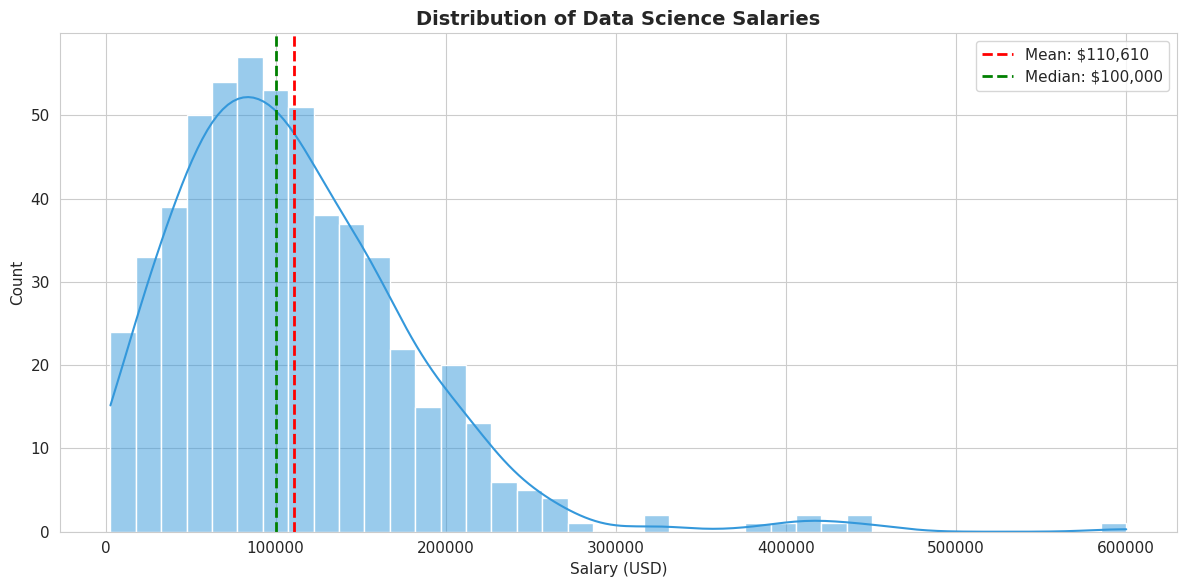

Mean: $110,610
Median: $100,000
Std Dev: $72,281


In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(df['salary'], bins=40, kde=True, color='#3498db', ax=ax)

mean_sal = df['salary'].mean()
median_sal = df['salary'].median()

ax.axvline(mean_sal, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_sal:,.0f}')
ax.axvline(median_sal, color='green', linestyle='--', linewidth=2, label=f'Median: ${median_sal:,.0f}')

ax.set_title('Distribution of Data Science Salaries', fontsize=14, fontweight='bold')
ax.set_xlabel('Salary (USD)')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.savefig('visualizations/01_salary_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Mean: ${mean_sal:,.0f}')
print(f'Median: ${median_sal:,.0f}')
print(f'Std Dev: ${df["salary"].std():,.0f}')

### 3.2 Salary by Experience Level

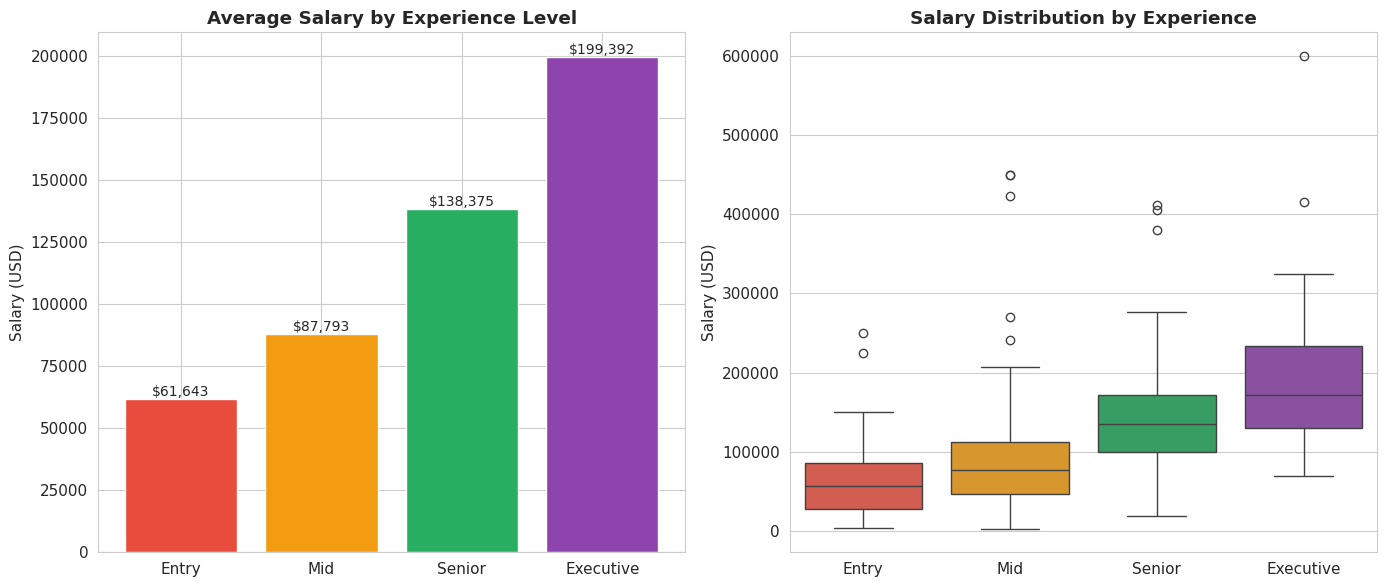

Salary by Experience Level:
  Entry: Mean=$61,643, Median=$56,500, Count=88
  Mid: Mean=$87,793, Median=$76,940, Count=208
  Senior: Mean=$138,375, Median=$135,000, Count=243
  Executive: Mean=$199,392, Median=$171,438, Count=26


In [15]:
exp_order = ['Entry', 'Mid', 'Senior', 'Executive']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# bar chart - mean salary
salary_by_exp = df.groupby('experience_level')['salary'].mean().reindex(exp_order)
colors = ['#e74c3c', '#f39c12', '#27ae60', '#8e44ad']

bars = axes[0].bar(salary_by_exp.index, salary_by_exp.values, color=colors)
axes[0].set_title('Average Salary by Experience Level', fontweight='bold')
axes[0].set_ylabel('Salary (USD)')

for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'${height:,.0f}', ha='center', va='bottom', fontsize=10)

# box plot
sns.boxplot(data=df, x='experience_level', y='salary', order=exp_order, palette=colors, ax=axes[1])
axes[1].set_title('Salary Distribution by Experience', fontweight='bold')
axes[1].set_ylabel('Salary (USD)')
axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('visualizations/02_salary_by_experience.png', dpi=150, bbox_inches='tight')
plt.show()

# print stats
print('Salary by Experience Level:')
for level in exp_order:
    data = df[df['experience_level'] == level]['salary']
    print(f'  {level}: Mean=${data.mean():,.0f}, Median=${data.median():,.0f}, Count={len(data)}')

### 3.3 Salary by Work Type

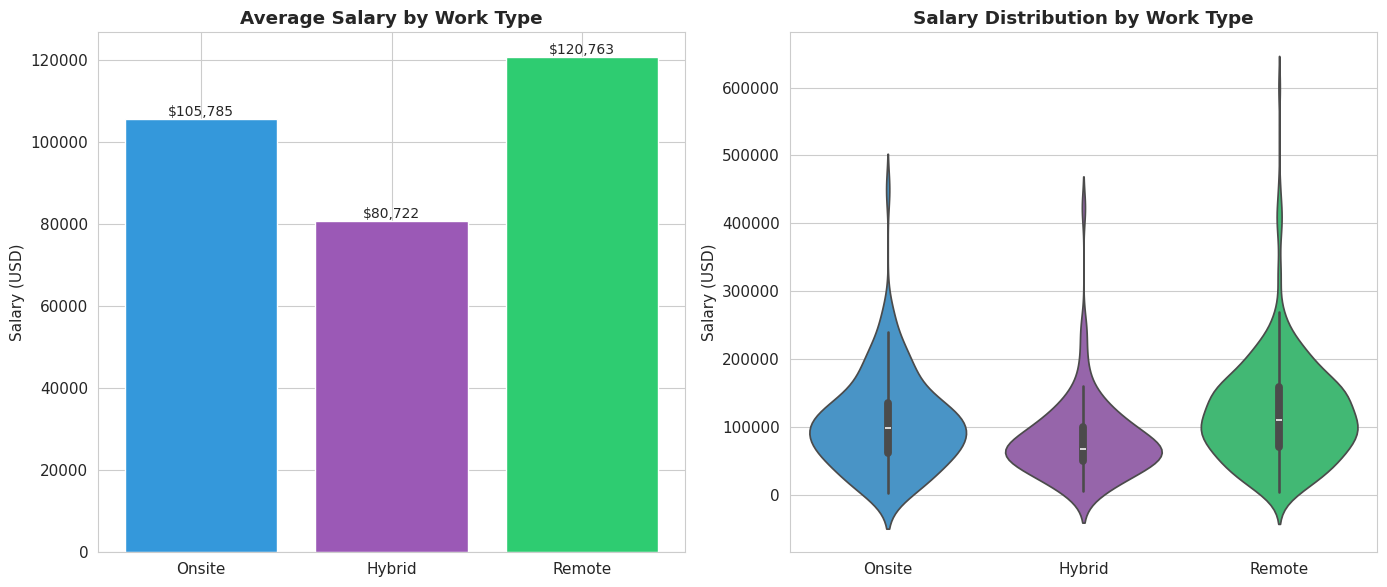

Work Type Distribution:
  Onsite: 121 jobs (21.4%)
  Hybrid: 98 jobs (17.3%)
  Remote: 346 jobs (61.2%)


In [16]:
work_order = ['Onsite', 'Hybrid', 'Remote']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# bar chart
salary_by_work = df.groupby('work_type')['salary'].mean().reindex(work_order)
colors = ['#3498db', '#9b59b6', '#2ecc71']

bars = axes[0].bar(salary_by_work.index, salary_by_work.values, color=colors)
axes[0].set_title('Average Salary by Work Type', fontweight='bold')
axes[0].set_ylabel('Salary (USD)')

for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'${height:,.0f}', ha='center', va='bottom', fontsize=10)

# violin plot
sns.violinplot(data=df, x='work_type', y='salary', order=work_order, palette=colors, ax=axes[1])
axes[1].set_title('Salary Distribution by Work Type', fontweight='bold')
axes[1].set_ylabel('Salary (USD)')
axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('visualizations/03_salary_by_worktype.png', dpi=150, bbox_inches='tight')
plt.show()

# print distribution
print('Work Type Distribution:')
for wt in work_order:
    count = len(df[df['work_type'] == wt])
    pct = count / len(df) * 100
    print(f'  {wt}: {count} jobs ({pct:.1f}%)')

### 3.4 Salary by Company Size

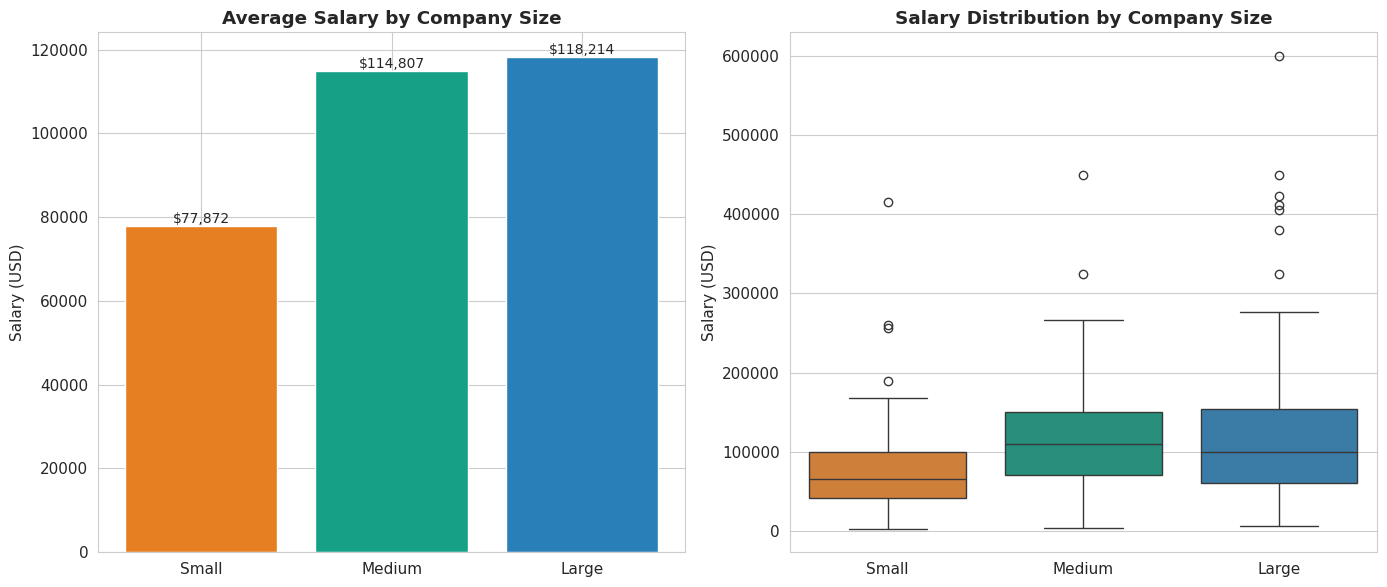

In [17]:
size_order = ['Small', 'Medium', 'Large']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# bar chart
salary_by_size = df.groupby('company_size')['salary'].mean().reindex(size_order)
colors = ['#e67e22', '#16a085', '#2980b9']

bars = axes[0].bar(salary_by_size.index, salary_by_size.values, color=colors)
axes[0].set_title('Average Salary by Company Size', fontweight='bold')
axes[0].set_ylabel('Salary (USD)')

for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'${height:,.0f}', ha='center', va='bottom', fontsize=10)

# box plot
sns.boxplot(data=df, x='company_size', y='salary', order=size_order, palette=colors, ax=axes[1])
axes[1].set_title('Salary Distribution by Company Size', fontweight='bold')
axes[1].set_ylabel('Salary (USD)')
axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('visualizations/04_salary_by_company_size.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.5 Top Job Titles

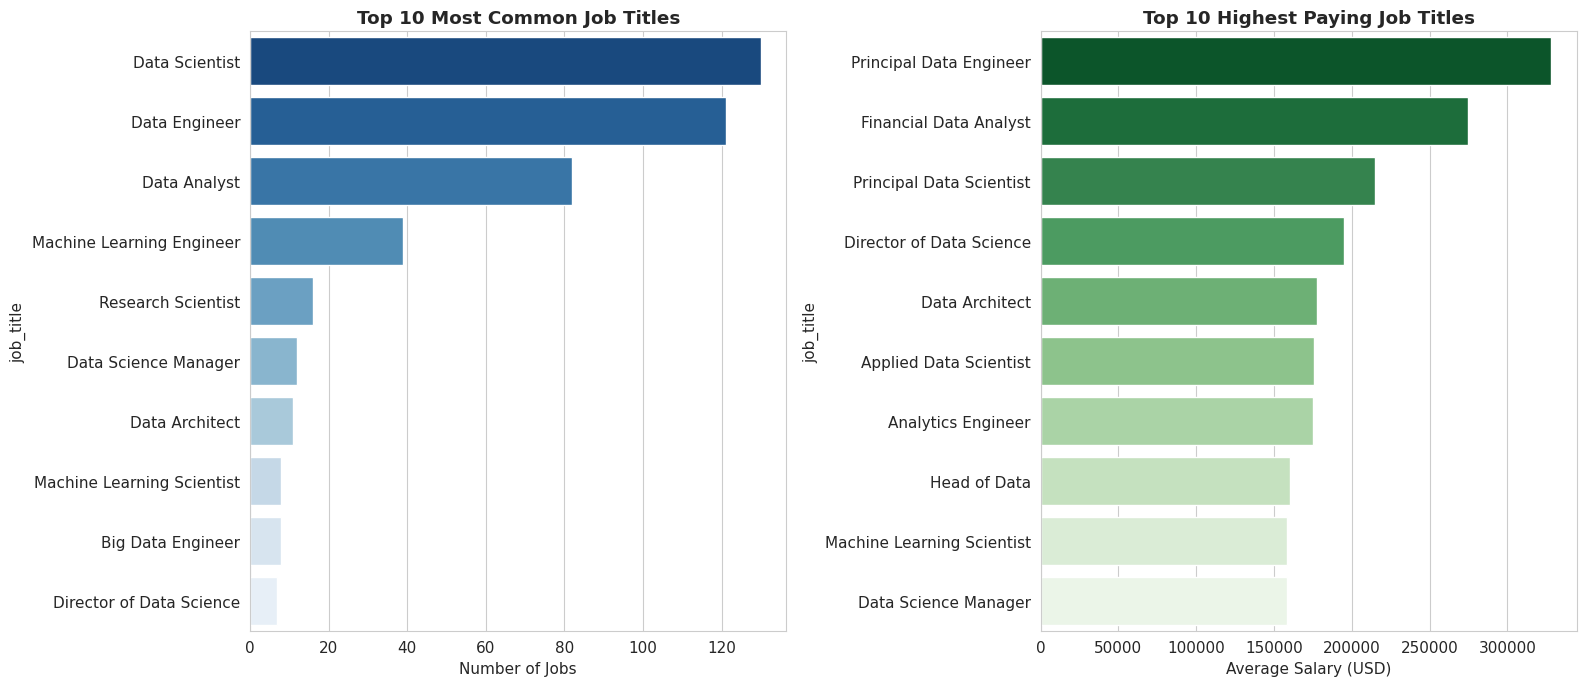

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# most common jobs
top_jobs = df['job_title'].value_counts().head(10)
sns.barplot(x=top_jobs.values, y=top_jobs.index, palette='Blues_r', ax=axes[0])
axes[0].set_title('Top 10 Most Common Job Titles', fontweight='bold')
axes[0].set_xlabel('Number of Jobs')

# highest paying jobs (with at least 2 occurrences)
job_counts = df['job_title'].value_counts()
valid_jobs = job_counts[job_counts >= 2].index
df_filtered = df[df['job_title'].isin(valid_jobs)]

top_paying = df_filtered.groupby('job_title')['salary'].mean().nlargest(10)
sns.barplot(x=top_paying.values, y=top_paying.index, palette='Greens_r', ax=axes[1])
axes[1].set_title('Top 10 Highest Paying Job Titles', fontweight='bold')
axes[1].set_xlabel('Average Salary (USD)')

plt.tight_layout()
plt.savefig('visualizations/05_top_job_titles.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.6 Yearly Trends

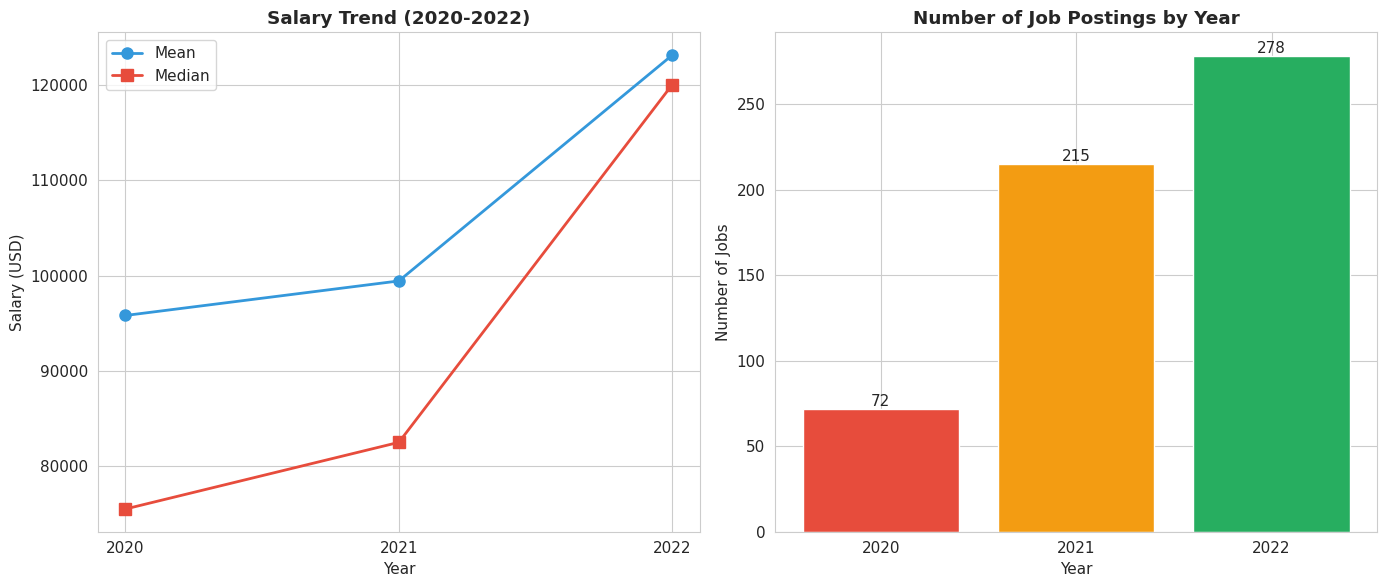

Year-over-Year Stats:
  2020: Mean=$95,813, Median=$75,544, Jobs=72
  2021: Mean=$99,430, Median=$82,528, Jobs=215
  2022: Mean=$123,089, Median=$120,000, Jobs=278


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

yearly = df.groupby('work_year').agg({'salary': ['mean', 'median', 'count']}).reset_index()
yearly.columns = ['year', 'mean', 'median', 'count']

# salary trend
axes[0].plot(yearly['year'], yearly['mean'], marker='o', linewidth=2, markersize=8, label='Mean', color='#3498db')
axes[0].plot(yearly['year'], yearly['median'], marker='s', linewidth=2, markersize=8, label='Median', color='#e74c3c')
axes[0].set_title('Salary Trend (2020-2022)', fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Salary (USD)')
axes[0].legend()
axes[0].set_xticks([2020, 2021, 2022])

# job count trend
bars = axes[1].bar(yearly['year'], yearly['count'], color=['#e74c3c', '#f39c12', '#27ae60'])
axes[1].set_title('Number of Job Postings by Year', fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Jobs')
axes[1].set_xticks([2020, 2021, 2022])

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('visualizations/06_yearly_trends.png', dpi=150, bbox_inches='tight')
plt.show()

print('Year-over-Year Stats:')
for _, row in yearly.iterrows():
    print(f"  {int(row['year'])}: Mean=${row['mean']:,.0f}, Median=${row['median']:,.0f}, Jobs={int(row['count'])}")

### 3.7 Geographic Analysis

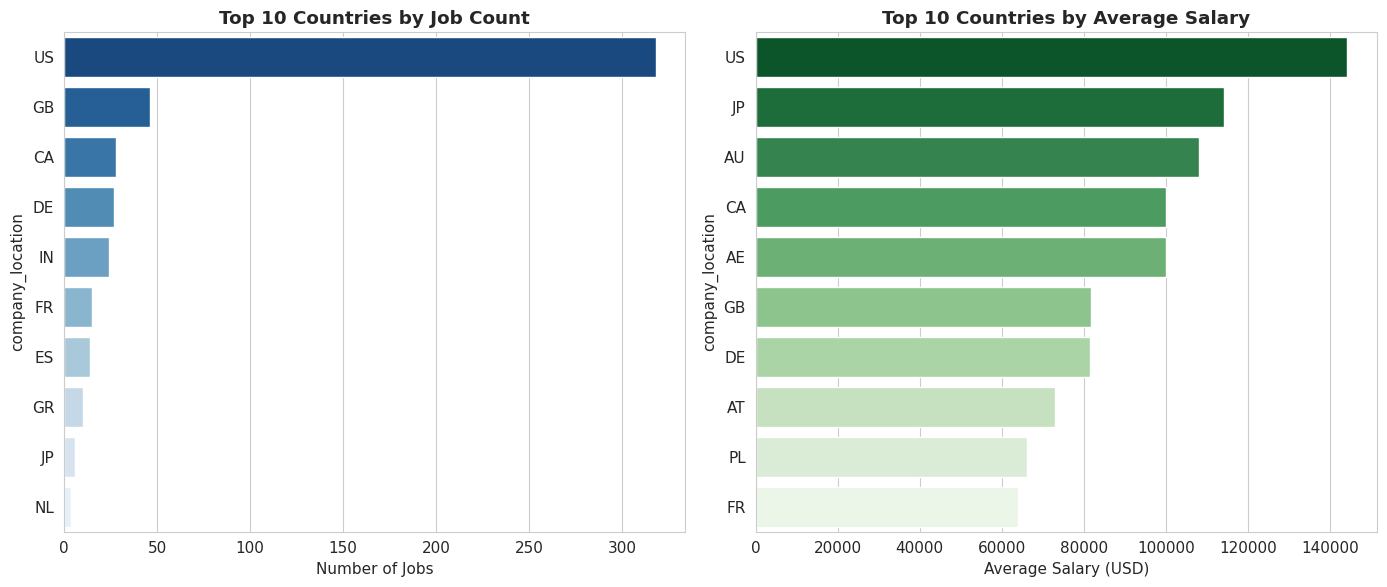

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# top countries by job count
top_countries = df['company_location'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='Blues_r', ax=axes[0])
axes[0].set_title('Top 10 Countries by Job Count', fontweight='bold')
axes[0].set_xlabel('Number of Jobs')

# top countries by salary (min 3 jobs)
country_counts = df['company_location'].value_counts()
valid_countries = country_counts[country_counts >= 3].index
df_countries = df[df['company_location'].isin(valid_countries)]

top_salary_countries = df_countries.groupby('company_location')['salary'].mean().nlargest(10)
sns.barplot(x=top_salary_countries.values, y=top_salary_countries.index, palette='Greens_r', ax=axes[1])
axes[1].set_title('Top 10 Countries by Average Salary', fontweight='bold')
axes[1].set_xlabel('Average Salary (USD)')

plt.tight_layout()
plt.savefig('visualizations/07_geographic_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.8 Distribution Charts (Pie)

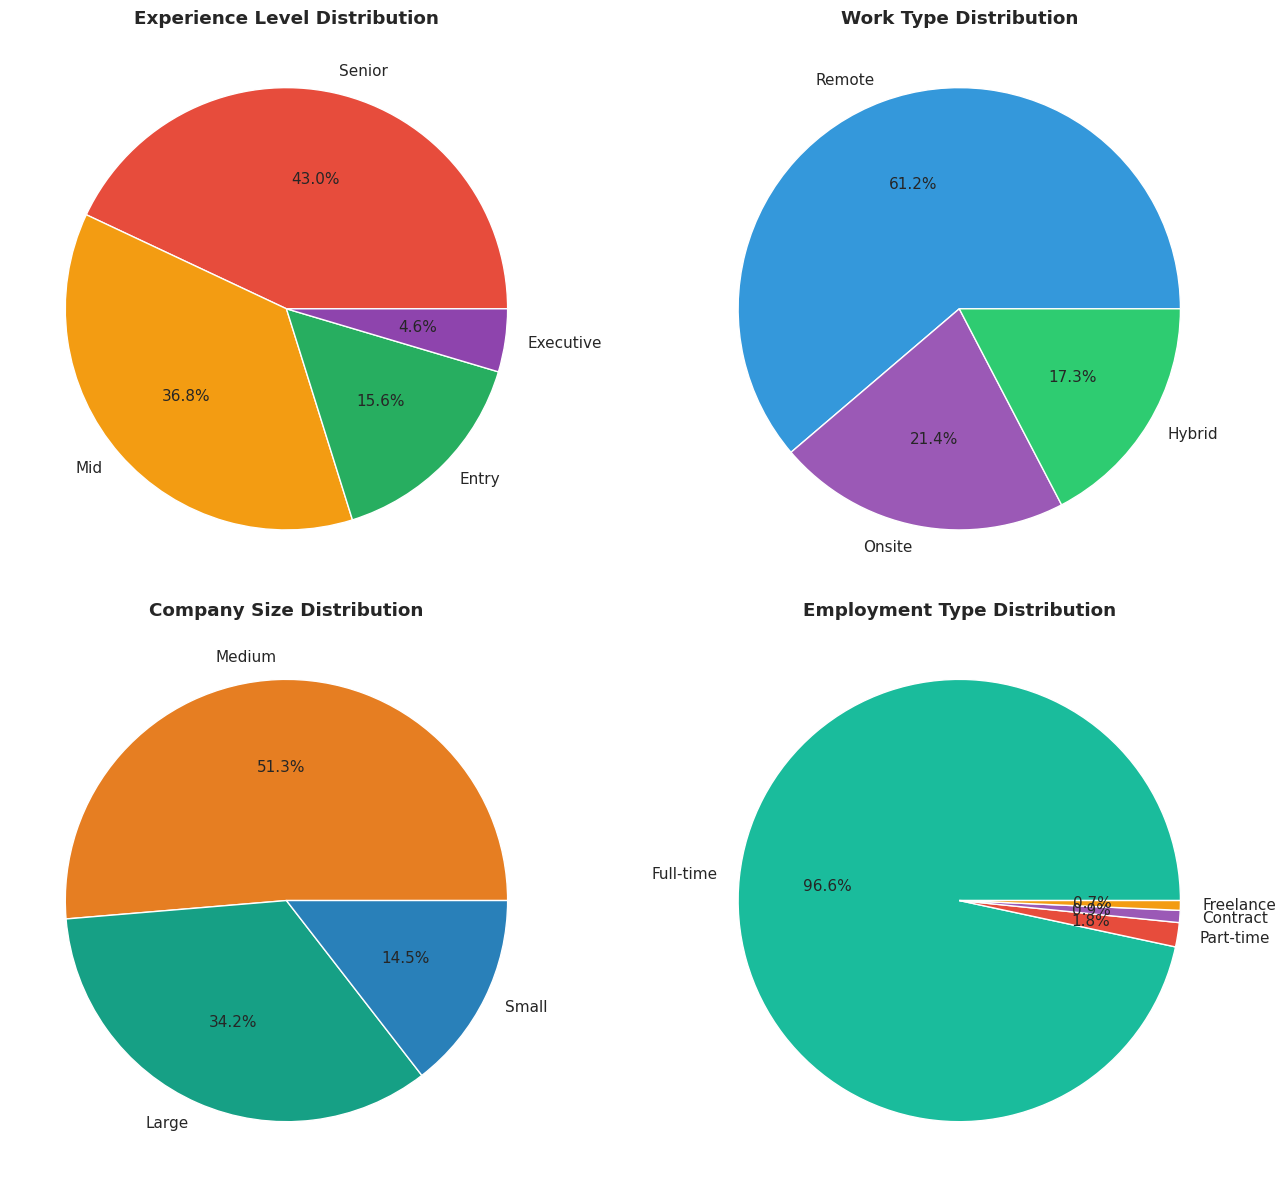

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# experience level
exp_counts = df['experience_level'].value_counts()
axes[0, 0].pie(exp_counts, labels=exp_counts.index, autopct='%1.1f%%', colors=['#e74c3c', '#f39c12', '#27ae60', '#8e44ad'])
axes[0, 0].set_title('Experience Level Distribution', fontweight='bold')

# work type
work_counts = df['work_type'].value_counts()
axes[0, 1].pie(work_counts, labels=work_counts.index, autopct='%1.1f%%', colors=['#3498db', '#9b59b6', '#2ecc71'])
axes[0, 1].set_title('Work Type Distribution', fontweight='bold')

# company size
size_counts = df['company_size'].value_counts()
axes[1, 0].pie(size_counts, labels=size_counts.index, autopct='%1.1f%%', colors=['#e67e22', '#16a085', '#2980b9'])
axes[1, 0].set_title('Company Size Distribution', fontweight='bold')

# employment type
emp_counts = df['employment_type'].value_counts()
axes[1, 1].pie(emp_counts, labels=emp_counts.index, autopct='%1.1f%%', colors=['#1abc9c', '#e74c3c', '#9b59b6', '#f39c12'])
axes[1, 1].set_title('Employment Type Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/08_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.9 Correlation Analysis

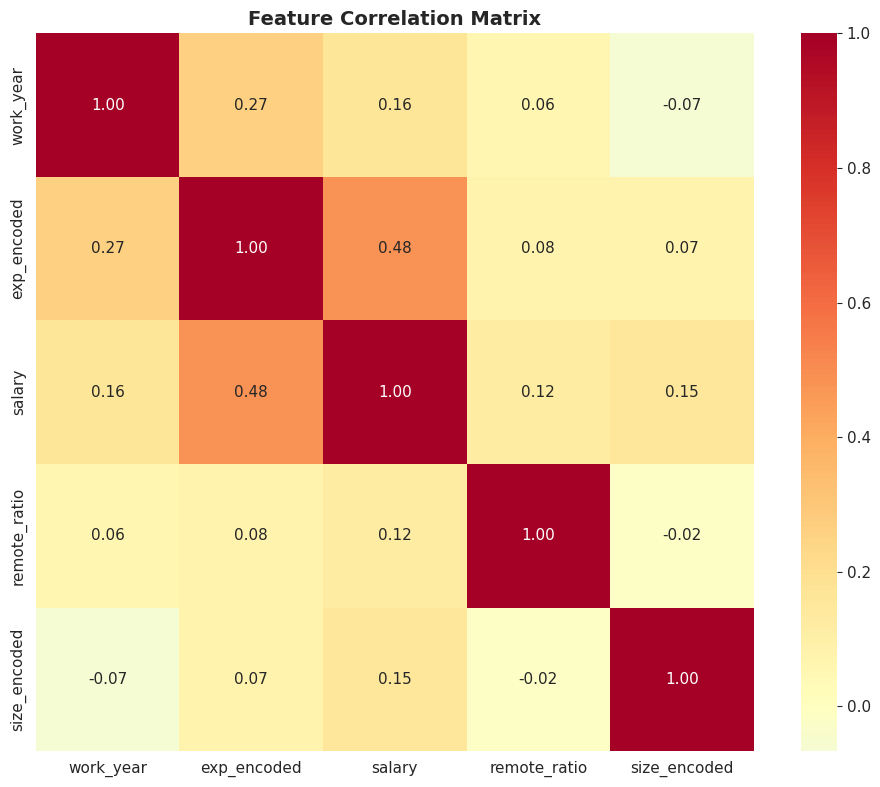

In [22]:
# encode for correlation
df_corr = df.copy()
df_corr['exp_encoded'] = df_corr['experience_level'].map({'Entry': 0, 'Mid': 1, 'Senior': 2, 'Executive': 3})
df_corr['size_encoded'] = df_corr['company_size'].map({'Small': 0, 'Medium': 1, 'Large': 2})
df_corr['work_encoded'] = df_corr['work_type'].map({'Onsite': 0, 'Hybrid': 1, 'Remote': 2})

corr_cols = ['work_year', 'exp_encoded', 'salary', 'remote_ratio', 'size_encoded']
corr_matrix = df_corr[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, square=True, fmt='.2f', ax=ax)
ax.set_title('Feature Correlation Matrix', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('visualizations/09_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.10 Multi-factor Analysis

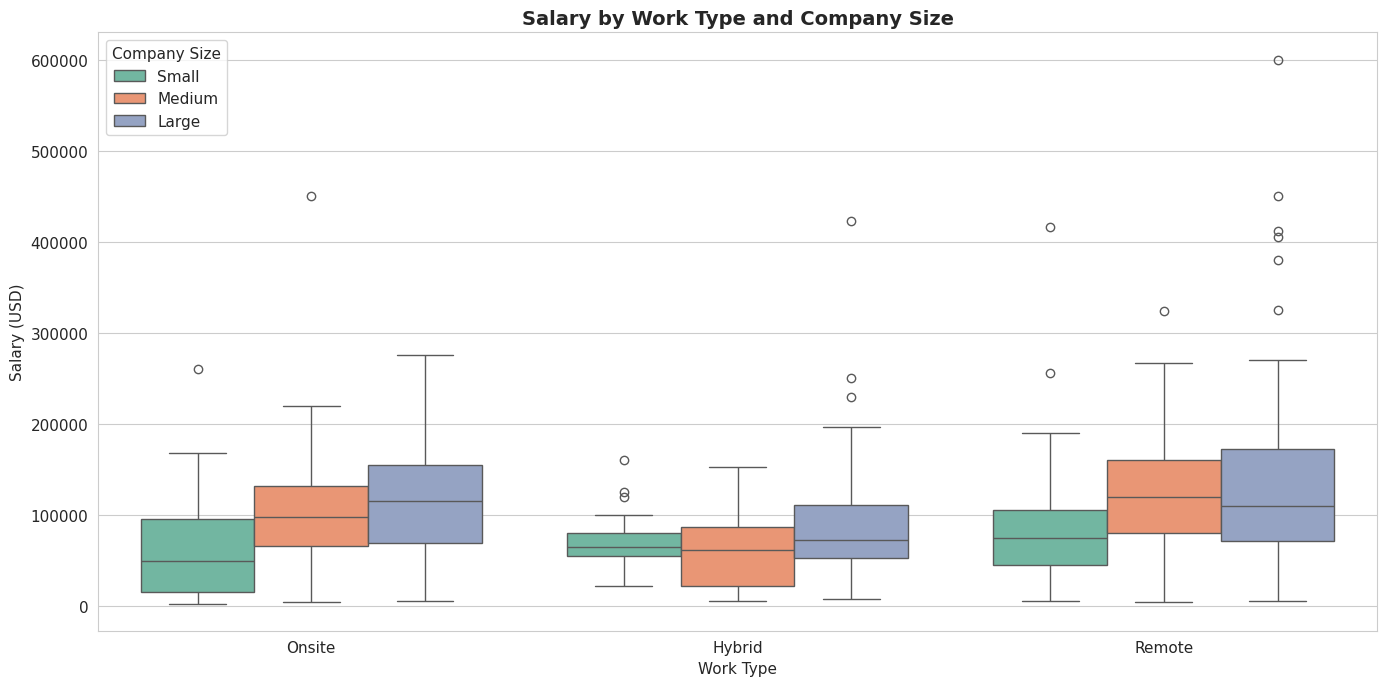

In [23]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.boxplot(data=df, x='work_type', y='salary', hue='company_size',
            order=work_order, hue_order=size_order, palette='Set2', ax=ax)

ax.set_title('Salary by Work Type and Company Size', fontweight='bold', fontsize=14)
ax.set_xlabel('Work Type')
ax.set_ylabel('Salary (USD)')
ax.legend(title='Company Size')

plt.tight_layout()
plt.savefig('visualizations/10_worktype_size_salary.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Statistical Summary

In [24]:
print('='*60)
print('STATISTICAL SUMMARY')
print('='*60)

print('\nSALARY STATISTICS:')
print(f'  Mean: ${df["salary"].mean():,.0f}')
print(f'  Median: ${df["salary"].median():,.0f}')
print(f'  Std Dev: ${df["salary"].std():,.0f}')
print(f'  Min: ${df["salary"].min():,.0f}')
print(f'  Max: ${df["salary"].max():,.0f}')

print('\nBY EXPERIENCE:')
for level in exp_order:
    mean = df[df['experience_level']==level]['salary'].mean()
    print(f'  {level}: ${mean:,.0f}')

print('\nBY WORK TYPE:')
for wt in work_order:
    mean = df[df['work_type']==wt]['salary'].mean()
    pct = len(df[df['work_type']==wt]) / len(df) * 100
    print(f'  {wt}: ${mean:,.0f} ({pct:.1f}% of jobs)')

print('\nBY COMPANY SIZE:')
for size in size_order:
    mean = df[df['company_size']==size]['salary'].mean()
    print(f'  {size}: ${mean:,.0f}')

STATISTICAL SUMMARY

SALARY STATISTICS:
  Mean: $110,610
  Median: $100,000
  Std Dev: $72,281
  Min: $2,859
  Max: $600,000

BY EXPERIENCE:
  Entry: $61,643
  Mid: $87,793
  Senior: $138,375
  Executive: $199,392

BY WORK TYPE:
  Onsite: $105,785 (21.4% of jobs)
  Hybrid: $80,722 (17.3% of jobs)
  Remote: $120,763 (61.2% of jobs)

BY COMPANY SIZE:
  Small: $77,872
  Medium: $114,807
  Large: $118,214


## 5. Machine Learning - Salary Prediction

In [25]:
# prepare features
df_ml = df.copy()

# encode categorical variables
df_ml['exp_encoded'] = df_ml['experience_level'].map({'Entry': 0, 'Mid': 1, 'Senior': 2, 'Executive': 3})
df_ml['emp_encoded'] = df_ml['employment_type'].map({'Part-time': 0, 'Freelance': 1, 'Contract': 2, 'Full-time': 3})
df_ml['size_encoded'] = df_ml['company_size'].map({'Small': 0, 'Medium': 1, 'Large': 2})
df_ml['work_encoded'] = df_ml['work_type'].map({'Onsite': 0, 'Hybrid': 1, 'Remote': 2})

le_job = LabelEncoder()
df_ml['job_encoded'] = le_job.fit_transform(df_ml['job_title'])

le_loc = LabelEncoder()
df_ml['loc_encoded'] = le_loc.fit_transform(df_ml['company_location'])

# define features and target
features = ['work_year', 'exp_encoded', 'emp_encoded', 'size_encoded', 'work_encoded', 'job_encoded', 'loc_encoded']
X = df_ml[features]
y = df_ml['salary']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set: {len(X_train)} samples')
print(f'Test set: {len(X_test)} samples')

Training set: 452 samples
Test set: 113 samples


In [26]:
# train linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

lr_r2 = r2_score(y_test, y_pred_lr)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print('Linear Regression Results:')
print(f'  R² Score: {lr_r2:.4f}')
print(f'  MAE: ${lr_mae:,.0f}')
print(f'  RMSE: ${lr_rmse:,.0f}')

Linear Regression Results:
  R² Score: 0.3187
  MAE: $37,216
  RMSE: $57,210


In [27]:
# train random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print('Random Forest Results:')
print(f'  R² Score: {rf_r2:.4f}')
print(f'  MAE: ${rf_mae:,.0f}')
print(f'  RMSE: ${rf_rmse:,.0f}')

Random Forest Results:
  R² Score: 0.2825
  MAE: $33,513
  RMSE: $58,711


In [28]:
# feature importance
importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print('Feature Importance (Random Forest):')
for _, row in importance.iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

Feature Importance (Random Forest):
  loc_encoded: 0.329
  job_encoded: 0.300
  exp_encoded: 0.217
  size_encoded: 0.055
  work_year: 0.051
  work_encoded: 0.035
  emp_encoded: 0.014


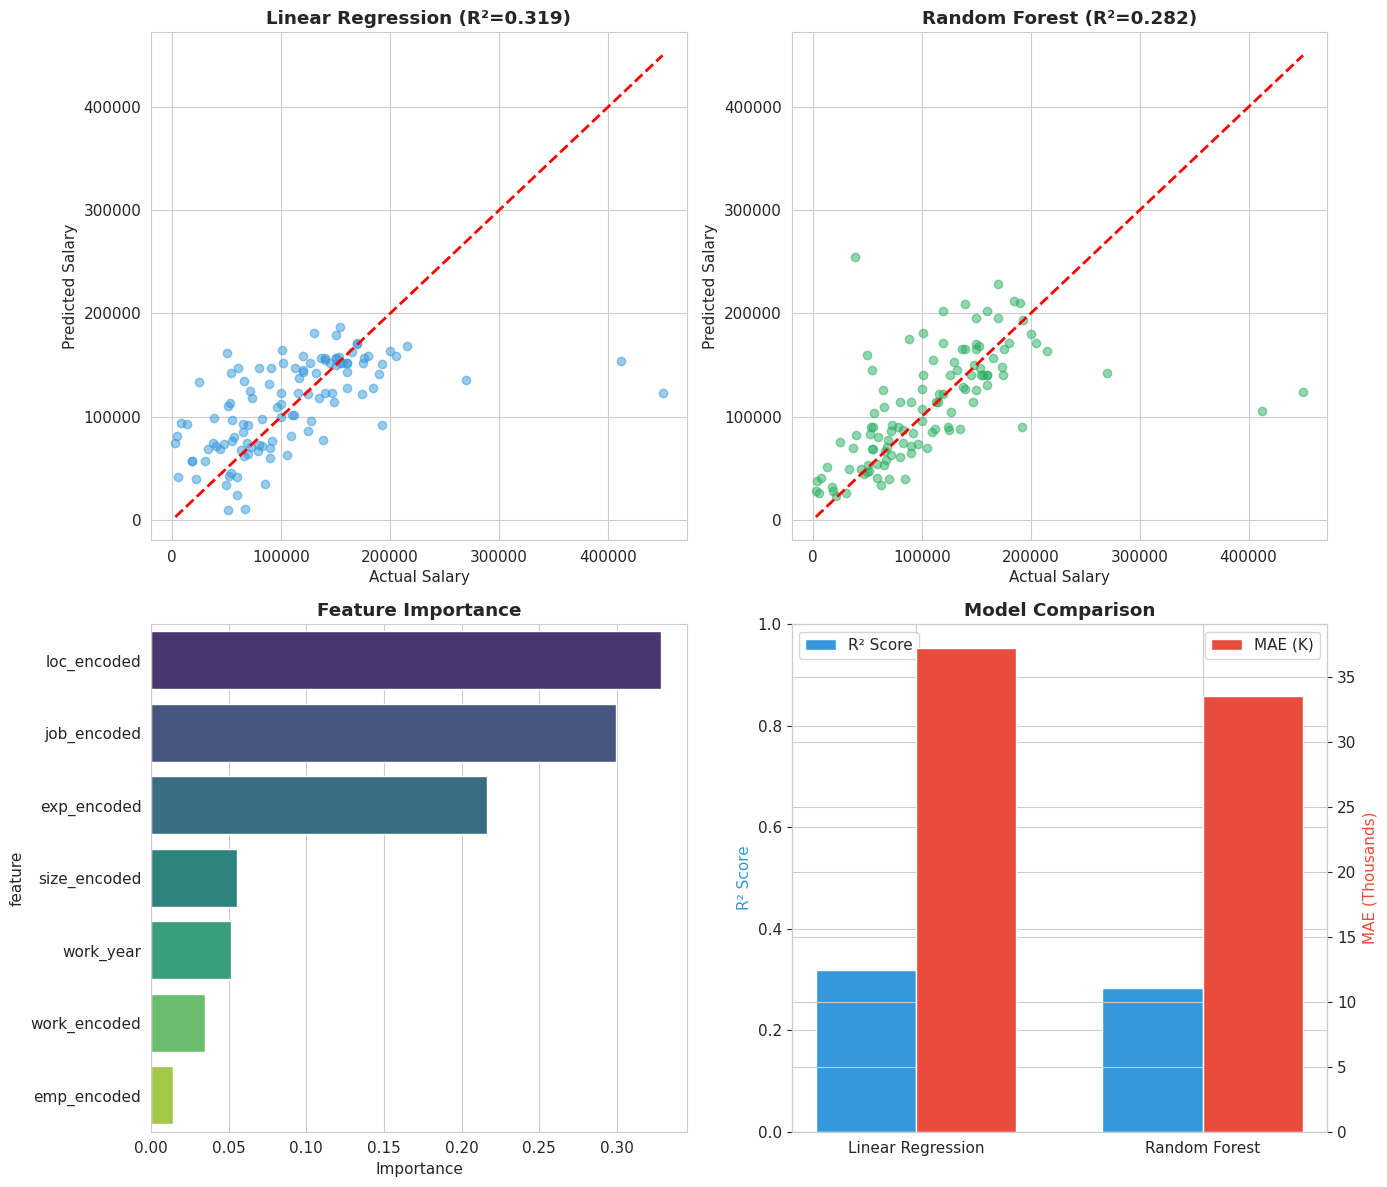

In [29]:
# model evaluation visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# linear regression: actual vs predicted
axes[0, 0].scatter(y_test, y_pred_lr, alpha=0.5, color='#3498db')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0, 0].set_title(f'Linear Regression (R²={lr_r2:.3f})', fontweight='bold')
axes[0, 0].set_xlabel('Actual Salary')
axes[0, 0].set_ylabel('Predicted Salary')

# random forest: actual vs predicted
axes[0, 1].scatter(y_test, y_pred_rf, alpha=0.5, color='#27ae60')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[0, 1].set_title(f'Random Forest (R²={rf_r2:.3f})', fontweight='bold')
axes[0, 1].set_xlabel('Actual Salary')
axes[0, 1].set_ylabel('Predicted Salary')

# feature importance
sns.barplot(x='importance', y='feature', data=importance, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Feature Importance', fontweight='bold')
axes[1, 0].set_xlabel('Importance')

# model comparison
models = ['Linear Regression', 'Random Forest']
mae_vals = [lr_mae, rf_mae]
r2_vals = [lr_r2, rf_r2]

x = np.arange(len(models))
width = 0.35

ax1 = axes[1, 1]
bars1 = ax1.bar(x - width/2, r2_vals, width, label='R² Score', color='#3498db')
ax1.set_ylabel('R² Score', color='#3498db')
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, [m/1000 for m in mae_vals], width, label='MAE (K)', color='#e74c3c')
ax2.set_ylabel('MAE (Thousands)', color='#e74c3c')

ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title('Model Comparison', fontweight='bold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('visualizations/11_ml_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Dashboard Summary

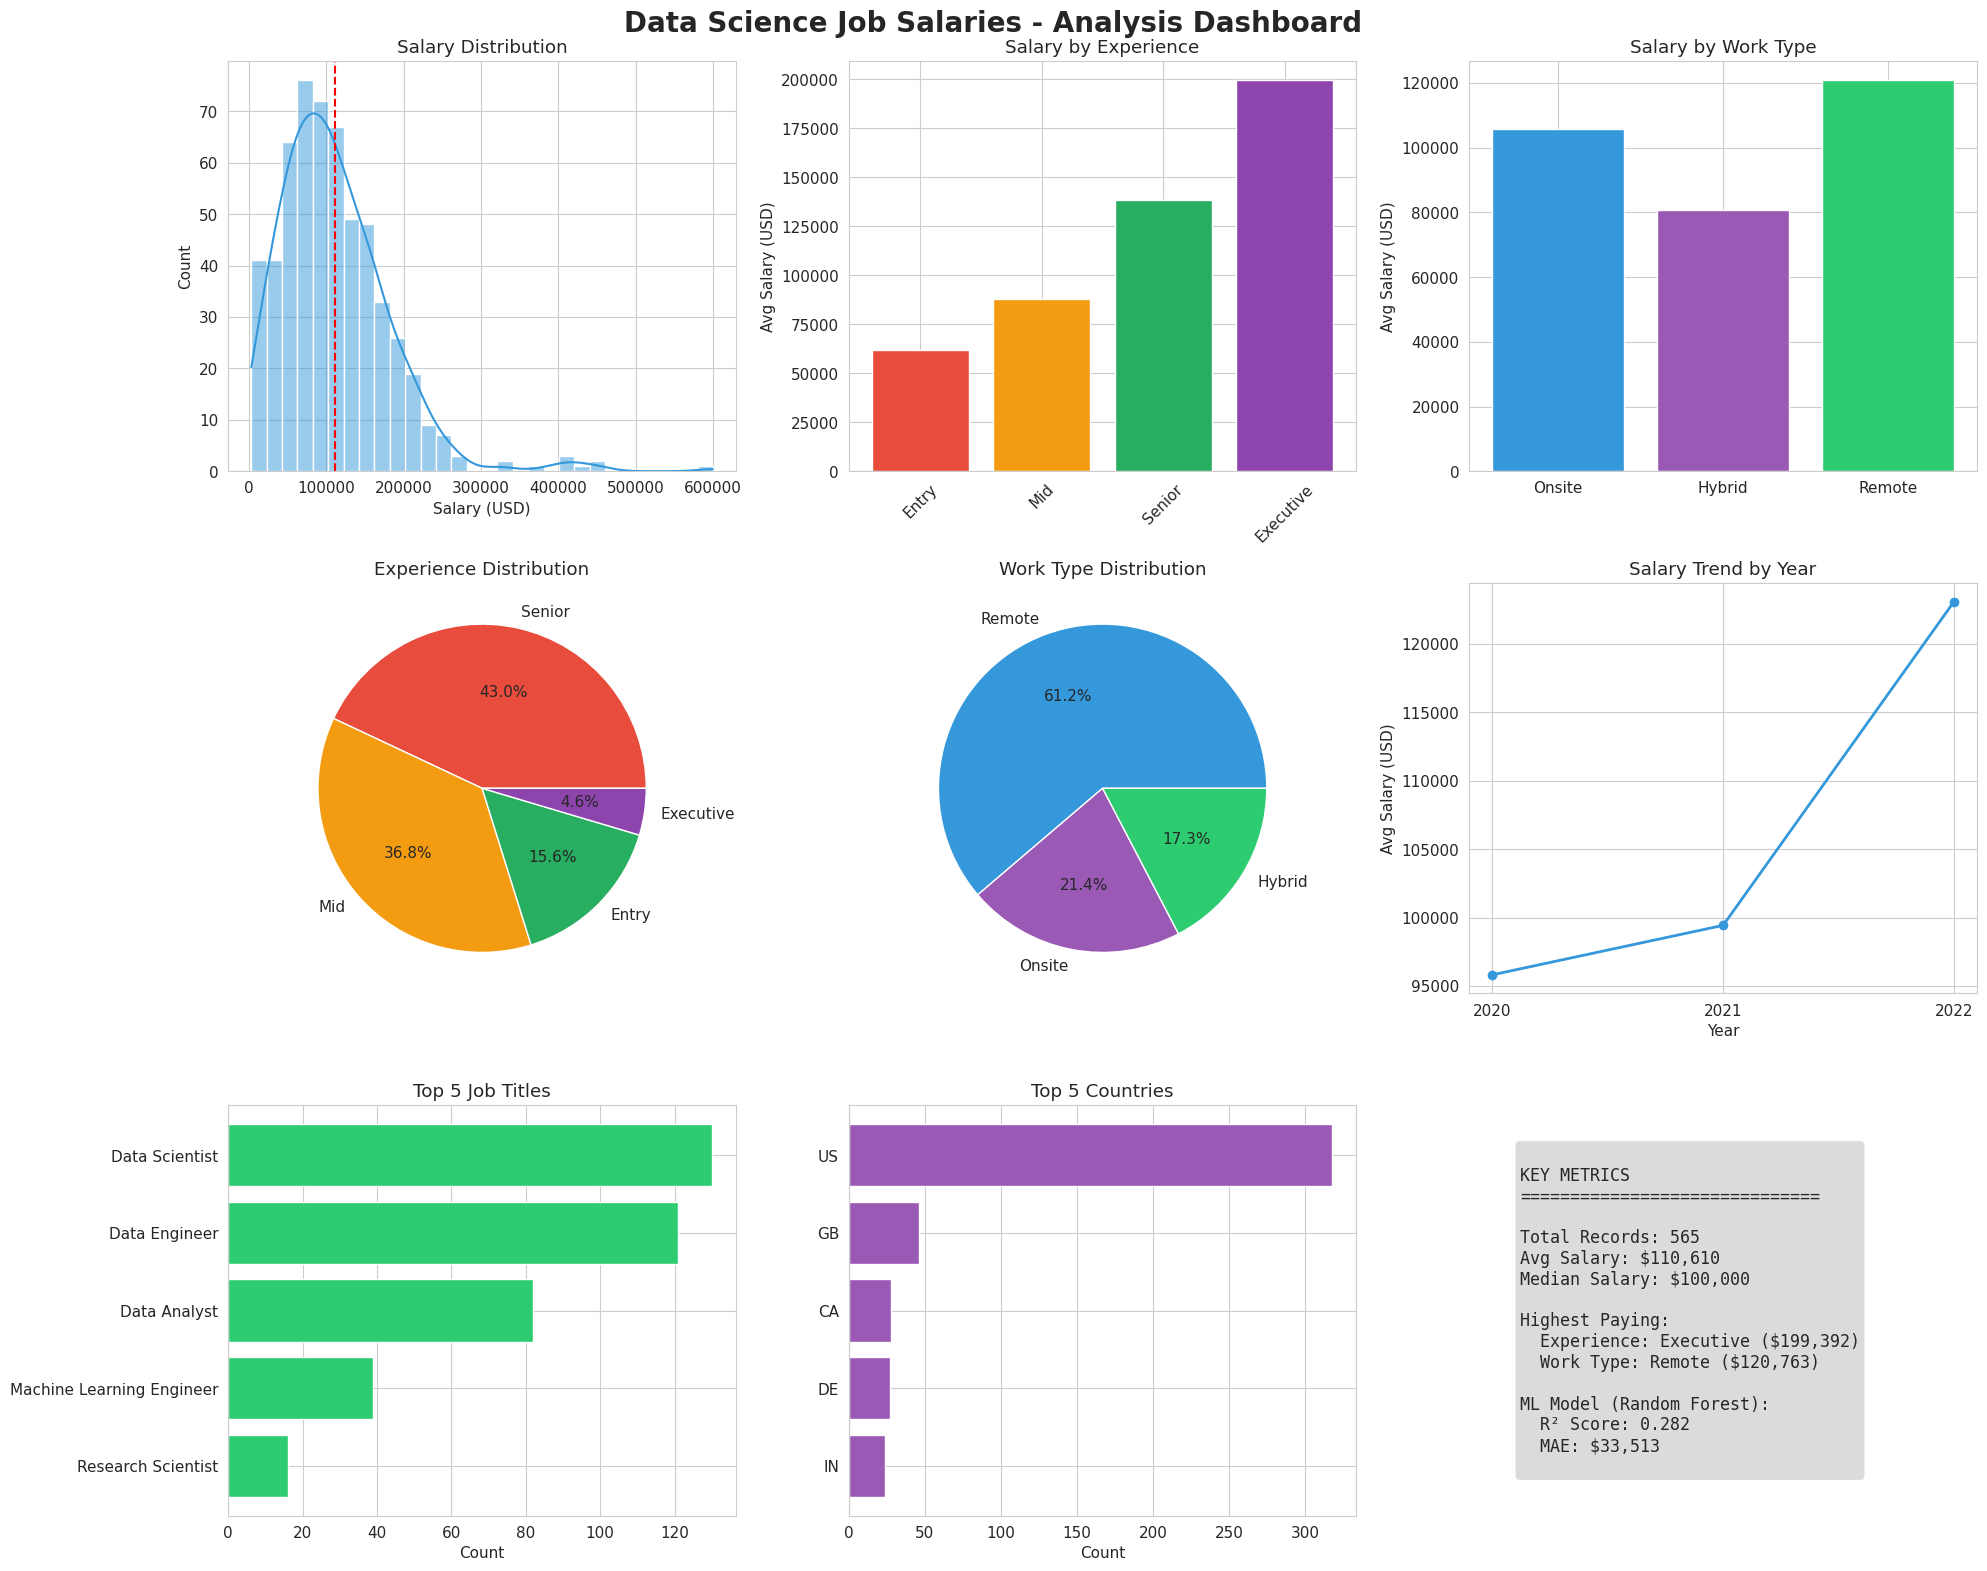

Dashboard saved!


In [30]:
# create a comprehensive dashboard
fig = plt.figure(figsize=(20, 16))

# title
fig.suptitle('Data Science Job Salaries - Analysis Dashboard', fontsize=20, fontweight='bold', y=0.98)

# 1. salary distribution
ax1 = fig.add_subplot(3, 3, 1)
sns.histplot(df['salary'], bins=30, kde=True, color='#3498db', ax=ax1)
ax1.axvline(df['salary'].mean(), color='red', linestyle='--')
ax1.set_title('Salary Distribution')
ax1.set_xlabel('Salary (USD)')

# 2. by experience
ax2 = fig.add_subplot(3, 3, 2)
salary_exp = df.groupby('experience_level')['salary'].mean().reindex(exp_order)
ax2.bar(salary_exp.index, salary_exp.values, color=['#e74c3c', '#f39c12', '#27ae60', '#8e44ad'])
ax2.set_title('Salary by Experience')
ax2.set_ylabel('Avg Salary (USD)')
ax2.tick_params(axis='x', rotation=45)

# 3. by work type
ax3 = fig.add_subplot(3, 3, 3)
salary_work = df.groupby('work_type')['salary'].mean().reindex(work_order)
ax3.bar(salary_work.index, salary_work.values, color=['#3498db', '#9b59b6', '#2ecc71'])
ax3.set_title('Salary by Work Type')
ax3.set_ylabel('Avg Salary (USD)')

# 4. experience distribution pie
ax4 = fig.add_subplot(3, 3, 4)
exp_counts = df['experience_level'].value_counts()
ax4.pie(exp_counts, labels=exp_counts.index, autopct='%1.1f%%', colors=['#e74c3c', '#f39c12', '#27ae60', '#8e44ad'])
ax4.set_title('Experience Distribution')

# 5. work type distribution pie
ax5 = fig.add_subplot(3, 3, 5)
work_counts = df['work_type'].value_counts()
ax5.pie(work_counts, labels=work_counts.index, autopct='%1.1f%%', colors=['#3498db', '#9b59b6', '#2ecc71'])
ax5.set_title('Work Type Distribution')

# 6. yearly trend
ax6 = fig.add_subplot(3, 3, 6)
yearly_mean = df.groupby('work_year')['salary'].mean()
ax6.plot(yearly_mean.index, yearly_mean.values, marker='o', linewidth=2, color='#3498db')
ax6.set_title('Salary Trend by Year')
ax6.set_xlabel('Year')
ax6.set_ylabel('Avg Salary (USD)')
ax6.set_xticks([2020, 2021, 2022])

# 7. top job titles
ax7 = fig.add_subplot(3, 3, 7)
top5_jobs = df['job_title'].value_counts().head(5)
ax7.barh(top5_jobs.index, top5_jobs.values, color='#2ecc71')
ax7.set_title('Top 5 Job Titles')
ax7.set_xlabel('Count')
ax7.invert_yaxis()

# 8. top countries
ax8 = fig.add_subplot(3, 3, 8)
top5_countries = df['company_location'].value_counts().head(5)
ax8.barh(top5_countries.index, top5_countries.values, color='#9b59b6')
ax8.set_title('Top 5 Countries')
ax8.set_xlabel('Count')
ax8.invert_yaxis()

# 9. key metrics text
ax9 = fig.add_subplot(3, 3, 9)
ax9.axis('off')
metrics_text = f"""
KEY METRICS
{'='*30}

Total Records: {len(df)}
Avg Salary: ${df['salary'].mean():,.0f}
Median Salary: ${df['salary'].median():,.0f}

Highest Paying:
  Experience: Executive (${df[df['experience_level']=='Executive']['salary'].mean():,.0f})
  Work Type: Remote (${df[df['work_type']=='Remote']['salary'].mean():,.0f})

ML Model (Random Forest):
  R² Score: {rf_r2:.3f}
  MAE: ${rf_mae:,.0f}
"""
ax9.text(0.1, 0.5, metrics_text, transform=ax9.transAxes, fontsize=12,
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('visualizations/12_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print('Dashboard saved!')

## 7. Conclusions

In [31]:
print('KEY FINDINGS')

print('\n1. SALARY OVERVIEW')
print(f'   Average salary: ${df["salary"].mean():,.0f}')
print(f'   Range: ${df["salary"].min():,.0f} to ${df["salary"].max():,.0f}')

print('\n2. EXPERIENCE MATTERS')
print(f'   Executive level earns ~${df[df["experience_level"]=="Executive"]["salary"].mean():,.0f}')
print(f'   Entry level earns ~${df[df["experience_level"]=="Entry"]["salary"].mean():,.0f}')
print('   Thats roughly 3x difference!')

print('\n3. REMOTE WORK PAYS MORE')
remote_pct = len(df[df['work_type']=='Remote']) / len(df) * 100
print(f'   Remote jobs: {remote_pct:.1f}% of all positions')
print(f'   Remote avg salary: ${df[df["work_type"]=="Remote"]["salary"].mean():,.0f}')
print(f'   Onsite avg salary: ${df[df["work_type"]=="Onsite"]["salary"].mean():,.0f}')

print('\n4. COMPANY SIZE')
print('   Large companies pay slightly more')
print('   Medium companies have most openings')

print('\n5. ML MODEL PERFORMANCE')
print(f'   Random Forest MAE: ${rf_mae:,.0f}')
print('   Top predictors: location, job title, experience')

print("="*60)
print('ANALYSIS COMPLETE')

KEY FINDINGS

1. SALARY OVERVIEW
   Average salary: $110,610
   Range: $2,859 to $600,000

2. EXPERIENCE MATTERS
   Executive level earns ~$199,392
   Entry level earns ~$61,643
   Thats roughly 3x difference!

3. REMOTE WORK PAYS MORE
   Remote jobs: 61.2% of all positions
   Remote avg salary: $120,763
   Onsite avg salary: $105,785

4. COMPANY SIZE
   Large companies pay slightly more
   Medium companies have most openings

5. ML MODEL PERFORMANCE
   Random Forest MAE: $33,513
   Top predictors: location, job title, experience
ANALYSIS COMPLETE


In [32]:
# list all saved files
print('Saved files:')
print('\nCleaned Data:')
print('  - cleaned_data/ds_salaries_cleaned.csv')

print('\nVisualizations:')
for f in sorted(os.listdir('visualizations')):
    print(f'  - visualizations/{f}')

Saved files:

Cleaned Data:
  - cleaned_data/ds_salaries_cleaned.csv

Visualizations:
  - visualizations/01_salary_distribution.png
  - visualizations/02_salary_by_experience.png
  - visualizations/03_salary_by_worktype.png
  - visualizations/04_salary_by_company_size.png
  - visualizations/05_top_job_titles.png
  - visualizations/06_yearly_trends.png
  - visualizations/07_geographic_analysis.png
  - visualizations/08_distributions.png
  - visualizations/09_correlation_heatmap.png
  - visualizations/10_worktype_size_salary.png
  - visualizations/11_ml_evaluation.png
  - visualizations/12_dashboard.png
